### 根据官方文档指导读取采样数据

In [1]:
import os
import operator
import random
import scipy.io as sio
import pickle as pickle
import numpy as np
import pandas as pd
from collections import OrderedDict

class DataSet(object):
    '''This class is used to arrange dataset, collected and used by Lab 119 in HIT.
        module numpy, pickle and pandas should be installed before used.
        Attributes:
            name: The name of dataset with str type. And this name is used to save and load the 
                dataset with the file name as 'DataSet_' + name + '.pkl'
            index: A list contained atrributes of the dataset, so that samples can be distinguished 
                from each others by different values under same attributes.
            save_path: A string described where to save or load this dataset, and defaulted as './data/'
            dataset: A list contained samples and their attributes.
    '''
    def __init__(self,name='',index=[],save_path='./data/',dataset=[]):
        self.name = name
        self.index = index
        self.save_path = save_path
        self.dataset = dataset

    # inner function
    def _deal_condition(self,condition):
        '''
        get the index of samples whose attributes is in condition.

        Args:
            condition: A dict whose keys are the name of attributes and values are lists contained values owned by 
                samples we need.
        Return:
            A bool list whether the sample need according to condition.
        '''
        conforming_idx_all = []
        for k in condition.keys():
            value_attribute = self.get_value_attribute(k)
            conforming_idx_all.append([x in condition[k] for x in value_attribute])
        conforming_idx = [True]*len(self.dataset)
        for x in conforming_idx_all:
            conforming_idx = conforming_idx and x
        return conforming_idx

    # modify
    def reset_index(self,index):
        assert isinstance(index,list)
        self.index = index

    def add_index(self,new_attribute,new_value=None):
        '''
        Add new attribute to dataset.
        
        Args:
            new_attribute: The name of new attribute (a string).
            new_value: A list contained values appended to each sample. If the length of new_value is 1,
                then all samples will append the same new_value. Or the length of new_value should be the
                same as the number of samples, then each sample will append the corresponding value. 
                Otherwise, raise valueError.
        Return:
            None
        '''
        self.index.append(new_attribute)
        if new_value == None:
            for x in self.dataset:
                x.append(new_value)
        elif isinstance(new_value,list):
            if len(new_value) == 1:
                for i in range(len(self.dataset)):
                    self.dataset[i].append(new_value[0])
            elif len(new_value) == len(self.dataset):
                for i in range(len(self.dataset)):
                    self.dataset[i].append(new_value[i])
            else:
                raise TypeError

    def del_index(self,del_attribute):
        '''
        delete attribute and the corresponding values in each sample.
        
        Args:
            del_attribute: The name of attribute (a string).
        Return:
            None
        '''
        try:
            idx = self.index.index(del_attribute)
            for x in self.dataset:
                del(x[idx])
            self.index.remove(del_attribute)
        except ValueError:
            raise ValueError
            print('The given attribute does not exist in index, and the attributes of this dataset \
                is ', self.index)

    def append(self,append_data):
        '''
        Append samples.
        
        Args:
            append_data: A dict or a list that contain a sample, including data and attribute.
        Return:
            None
        '''
        if isinstance(append_data,dict):
            if len(append_data.keys()) <= len(self.index):
                append_data_list = []
                for x in self.index:
                    if x in list(append_data.keys()):
                        append_data_list.append(append_data[x])
                    else:
                        append_data_list.append(None)
                self.dataset.append(append_data_list)
            else:
                raise ValueError('append_data has too much attribute!')
        elif isinstance(append_data,list):
            if len(append_data) == len(self.index):
                self.dataset.append(append_data)
            else:
                raise ValueError('append_data has wrong number of attribute!')
        else:
            raise TypeError('append_data should be dict or list')

    def delete(self,condition):
        '''
        delete samples.
        
        Args:
            condition: A dict determines which samples should be delete.
        Return:
            None
        '''
        conforming_idx = self._deal_condition(condition)
        for i,x in enumerate(self.dataset):
            if conforming_idx[i]:
                self.dataset.pop(x)

    # get information or values
    def get_value_attribute(self,attribute):
        '''
        get values under the given attribute of each data
        Args:
            attribute: A str mapping the attribute of dataset.
                Return error and all attribute of dataset if the given attribute does
                not exist.
        Return:
            A list of values under the given attribute with the same order as samples in dataset.
        '''
        try:
            idx = self.index.index(attribute)
            return [x[idx] for x in self.dataset]
        except ValueError:
            raise ValueError
            print('The given attribute does not exist in index, and the attributes of this dataset \
                is ', self.index)

    def get_value(self,attribute,condition={}):
        '''
        get corresponding values.
        
        Args:
            attribute: A string describes the values returned.
            condition: A dict determines the values of which samples should be returned.
        Return:
            A list contrained values by given attribute and condition.
        '''
        conforming_idx = self._deal_condition(condition)
        idx = self.index.index(attribute)
        return [x[idx] for i,x in enumerate(self.dataset) if conforming_idx[i]]

    def get_dataset(self,condition={}):
        '''
        get corresponding dataset.
        
        Args:
            condition: A dict determines the values of which samples should be returned.
        Return:
            A DataSet contrained values by given condition.
        '''
        conforming_idx = self._deal_condition(condition)
        return DataSet(name='temp',index=self.index,
                        dataset=[x for i,x in enumerate(self.dataset) if conforming_idx[i]])

    def get_random_choice(self):
        '''
        get a random sample.
        
        Args:
            None
        Return:
            A dict like {Attribute_1:Values,...}.
        '''
        r = {}
        data = random.choice(self.dataset)
        for i,k in enumerate(self.index):
            r[k] = data[i]
        return r

    def get_random_samples(self,n=1):
        '''
        get a random DataSet.
        
        Args:
            None
        Return:
            A Dataset with same index but only one sample.
        '''
        return DataSet(name='temp',index=self.index,dataset=random.sample(self.dataset,n))
    
    # value process
    def normalization(self,attribute,select='std'):
        idx = self.index.index(attribute)
        for i in range(len(self.dataset)):
            if select == 'fft':
                self.dataset[i][idx] = self.dataset[i][idx] / np.max(self.dataset[i][idx])
            else:
                self.dataset[i][idx] = self.dataset[i][idx] - np.mean(self.dataset[i][idx])
                if select == 'min-max':
                    self.dataset[i][idx] = self.dataset[i][idx] / max(np.max(self.dataset[i][idx]),abs(np.min(self.dataset[i][idx])))
                elif select == 'std':
                    self.dataset[i][idx] = self.dataset[i][idx] / np.std(self.dataset[i][idx])
                else:
                    raise ValueError

    # class operation
    def shuffle(self):
        random.shuffle(self.dataset)

    def random_sample(self,n):
        if isinstance(n,str):
            if n == 'all':
                self.shuffle()
            elif n == 'half':
                self.dataset = random.sample(self.dataset,int(len(self.dataset)/2))
            else:
                raise ValueError('n should be \'all\' or \'half\'!')
        elif isinstance(n,int):
            if n >= len(self.dataset):
                self.shuffle()
            else:
                self.dataset = random.sample(self.dataset,n)
        else:
            raise TypeError('n should be int of string!')

    def dataset_filter(self,condition={}):
        conforming_idx = self._deal_condition(condition)
        self.dataset = [x for i,x in enumerate(self.dataset) if conforming_idx[i]]

    def save(self):
        '''
        Save this DataSet as .pkl file.
        
        Args:
            None
        Return:
            None
        '''
        assert self.name != ''
        assert self.save_path != ''
        pickle.dump(self, open(self.save_path + 'DataSet_' +
                                     self.name + '.pkl', 'wb'), True)
        #self._save_info()
        print('dataset ', self.name, ' has benn saved\n')

    def _save_info(self):
        '''
        Save this DataSet' information as .csv file in the save_path.
        
        Args:
            None
        Return:
            None
        '''
        assert self.name != ''
        assert self.save_path != ''
        info = OrderedDict()
        for attr in self.index:
            info[attr] = self.get_value_attribute(attr)
            if isinstance(info[attr][0],np.ndarray) and len(info[attr][0])>1:
                for i,x in enumerate(info[attr]):
                    info[attr][i] = x.shape
            if not isinstance(info[attr][0],str) and len(info[attr][0]) > 2:
                for i,x in enumerate(info[attr]):
                    info[attr][i] = len(x)

        pd.DataFrame(info).to_csv(self.save_path + 'DataSet_' + self.name + 'info.csv',index=False)

    def load(self,name=''):
        '''
        Load this DataSet with name and path known, which should be given when initialize DataSet class.
        
        Args:
            name: The name of DataSet.
        Return:
            None
        '''
        if name != '':
            self.name = name
        assert self.name != ''
        assert self.save_path != ''
        full_name = self.save_path + 'DataSet_' + self.name + '.pkl'
        load_class = pickle.load(open(full_name, 'rb'))
        assert load_class.name == self.name
        assert load_class.save_path == self.save_path
        print('dataset ', self.name, ' has been load')
        self.dataset = load_class.dataset
        self.index = load_class.index

    @staticmethod
    def load_dataset(name):
        '''
        Load this DataSet with name and default path './'.
        
        Args:
            name: The name of DataSet.
        Return:
            DataSet
        '''
        save_path = './data/'
        full_name = save_path + 'DataSet_' + name + '.pkl'
        load_class = pickle.load(open(full_name,'rb'))
        print('dataset ', name, ' has been load')
        return load_class

In [2]:
def make_phm_dataset():
    RUL_dict = {'Bearing1_1':0, 'Bearing1_2':0,'Bearing1_3':0}
    phm_dataset = DataSet(name='phm_data',
                        index=['bearing_name','RUL','quantity','data'])
    source_path = './PHM/'
    for path_1 in ['Learning_set/','Test_set/']:
        bearings_names = os.listdir(source_path + path_1)
        bearings_names.sort()
        for bearings_name in bearings_names:
            if bearings_name == '.DS_Store':
                #过滤一下隐藏文件
                continue
            file_names = os.listdir(source_path + path_1 + bearings_name + '/')
            file_names.sort()
            bearing_data = np.array([])
            for file_name in file_names:
                if 'acc' in file_name:
                    df = pd.read_csv(source_path + path_1 + bearings_name + '/'\
                                    + file_name,header=None)
                    data = np.array(df.loc[:,4:6])
                    data = data[np.newaxis,:,:]
                    if bearing_data.size == 0:
                        bearing_data = data
                    else:
                        bearing_data = np.append(bearing_data,data,axis=0)
        
            phm_dataset.append([bearings_name,RUL_dict[bearings_name],bearing_data.shape[0],bearing_data])
            print(bearings_name,'has been appended.')

    phm_dataset.save()

make_phm_dataset()
dataset = DataSet.load_dataset('phm_data')

Bearing1_1 has been appended.
Bearing1_2 has been appended.
Bearing1_3 has been appended.
dataset  phm_data  has benn saved

dataset  phm_data  has been load


In [3]:
data_length = dataset.get_value('quantity',condition={'bearing_name':['Bearing1_1','Bearing1_2','Bearing1_3']})
temp_data = dataset.get_value('data',condition={'bearing_name':['Bearing1_1','Bearing1_2','Bearing1_3']})
temp_label = dataset.get_value('RUL',condition={'bearing_name':['Bearing1_1','Bearing1_2','Bearing1_3']})

train_data = np.array([])
train_label = np.array([])
for i,x in enumerate(temp_label):
    t_label = [y for y in range(round(x),round(x + temp_data[i].shape[0]))]
    t_label.reverse()
    if train_data.size == 0:
        train_data = temp_data[i]
        train_label = np.array(t_label)/data_length[i]
    else:
        train_data = np.append(train_data,temp_data[i],axis=0)
        train_label = np.append(train_label,np.array(t_label)/data_length[i],axis=0)
assert train_data.shape[0] == train_label.shape[0]
is_random = False
if is_random:
    idx = [x for x in range(train_data.shape[0])]
    random.shuffle(idx)
    train_data = train_data[idx]
    train_label = train_label[idx]
final_data = np.transpose(train_data,(0,2,1)),train_label[:,np.newaxis]

In [4]:
data_length

[2803, 871, 1802]

In [5]:
x = final_data[0]
y = final_data[1]

### 根据采样数据生成时域和频域特征

In [6]:
''' ============== 特征提取的类 =====================
时域特征 ：11类
频域特征 : 12类
总共提取特征 ： 23类
参考文献 英文文献 016_C_(Q1 时域和频域共23种特征参数 )  Fault diagnosis of rotating machinery based on multiple ANFIS combination with GAs
'''
import numpy as np

import scipy.stats
import matplotlib.pyplot as plt

class Fea_Extra():
    def __init__(self, Signal, Fs = 25600):
        self.signal = Signal
        self.Fs = Fs

    def Time_fea(self, signal_):
        """
        提取时域特征 11 类
        """
        N = len(signal_)
        y = signal_
        t_mean_1 = np.mean(y)                                    # 1_均值（平均幅值）

        t_std_2  = np.std(y, ddof=1)                             # 2_标准差

        t_fgf_3  = ((np.mean(np.sqrt(np.abs(y)))))**2           # 3_方根幅值

        t_rms_4  = np.sqrt((np.mean(y**2)))                      # 4_RMS均方根

        t_pp_5   = 0.5*(np.max(y)-np.min(y))                     # 5_峰峰值

        #t_skew_6   = np.sum((t_mean_1)**3)/((N-1)*(t_std_3)**3)
        t_skew_6   = scipy.stats.skew(y)                         # 6_偏度 skewness

        #t_kur_7   = np.sum((y-t_mean_1)**4)/((N-1)*(t_std_3)**4)
        t_kur_7 = scipy.stats.kurtosis(y)                        # 7_峭度 Kurtosis

        t_cres_8  = np.max(np.abs(y))/t_rms_4                    # 8_峰值因子 Crest Factor

        t_clear_9  = np.max(np.abs(y))/t_fgf_3                   # 9_裕度因子  Clearance Factor

        t_shape_10 = (N * t_rms_4)/(np.sum(np.abs(y)))           # 10_波形因子 Shape fator

        t_imp_11  = ( np.max(np.abs(y)))/(np.mean(np.abs(y)))  # 11_脉冲指数 Impulse Fator

        t_fea = np.array([t_mean_1, t_std_2, t_fgf_3, t_rms_4, t_pp_5,
                          t_skew_6,   t_kur_7,  t_cres_8,  t_clear_9, t_shape_10, t_imp_11 ])

        #print("t_fea:",t_fea.shape,'\n', t_fea)
        return t_fea

    def Fre_fea(self, signal_):
        """
        提取频域特征 13类
        :param signal_:
        :return:
        """
        L = len(signal_)
        PL = abs(np.fft.fft(signal_ / L))[: int(L / 2)]
        PL[0] = 0
        f = np.fft.fftfreq(L, 1 / self.Fs)[: int(L / 2)]
        x = f
        y = PL
        K = len(y)
        # print("signal_.shape:",signal_.shape)
        # print("PL.shape:", PL.shape)
        # print("L:", L)
        # print("K:", K)
        # print("x:",x)
        # print("y:",y)

        f_12 = np.mean(y)

        f_13 = np.var(y)

        f_14 = (np.sum((y - f_12)**3))/(K * ((np.sqrt(f_13))**3))

        f_15 = (np.sum((y - f_12)**4))/(K * ((f_13)**2))

        f_16 = (np.sum(x * y))/(np.sum(y))

        f_17 = np.sqrt((np.mean(((x- f_16)**2)*(y))))

        f_18 = np.sqrt((np.sum((x**2)*y))/(np.sum(y)))

        f_19 = np.sqrt((np.sum((x**4)*y))/(np.sum((x**2)*y)))

        f_20 = (np.sum((x**2)*y))/(np.sqrt((np.sum(y))*(np.sum((x**4)*y))))

        f_21 = f_17/f_16

        f_22 = (np.sum(((x - f_16)**3)*y))/(K * (f_17**3))

        f_23 = (np.sum(((x - f_16)**4)*y))/(K * (f_17**4))

        #f_24 = (np.sum((np.sqrt(x - f_16))*y))/(K * np.sqrt(f_17))


        #print("f_16:",f_16)

        #f_fea = np.array([f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24])
        f_fea = np.array([f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23])

        #print("f_fea:",f_fea.shape,'\n', f_fea)
        return f_fea

    def Both_Fea(self):
        """
        :return: 时域、频域特征 array
        """
        t_fea = self.Time_fea(self.signal)
        f_fea = self.Fre_fea(self.signal)
        fea = np.append(np.array(t_fea), np.array(f_fea))
        #print("fea:", fea.shape, '\n', fea)
        return fea

In [7]:
len(x)

5476

In [8]:
Fea_Extra(x[0][0]).Both_Fea()

array([ 3.46523437e-03,  5.61844716e-01,  3.83144707e-01,  5.61745658e-01,
        1.88650000e+00, -4.71106708e-03, -1.31465028e-01,  3.57813180e+00,
        5.24605969e+00,  1.24590434e+00,  4.45800992e+00,  6.50591923e-03,
        8.09279408e-05,  3.93345806e+00,  2.84447481e+01,  4.39026545e+03,
        2.16271241e+02,  5.14429473e+03,  8.24234390e+03,  6.24130077e-01,
        4.92615408e-02,  1.38565064e+01,  6.44050717e+02])

In [9]:
X = []
for i in range(len(x)):
    temp1 = Fea_Extra(x[i][0])
    x1_ = temp1.Both_Fea()
    temp2 = Fea_Extra(x[i][1])
    x2_ = temp2.Both_Fea()
    X.append(np.hstack((x1_,x2_)))
X = np.array(X)

In [10]:
X.shape,y.shape

((5476, 46), (5476, 1))

### 计算correlation monotonicity robust

In [11]:
import numpy as np

def monotonicity(x):
    dx = np.diff(x)
    return abs(len(np.where(dx >= 0)[0])) / (len(x) - 1)

def correlation(x):
    n = len(x)
    x = np.array(x)
    result = np.correlate(x[i:]-x[i:].mean(),x[:n-i]-x[:n-i].mean())[0] / (x[i:].std()*x[:n-i].std()*(n-i))
    return result


def robustness(x):
    return sum(np.exp(-abs((x - np.mean(x))/x))) /len(x)

In [12]:
mon_x = []
for i in range(X.shape[1]):
    mon_x.append(monotonicity(X[:,i]))
    
cor_x = []
for i in range(X.shape[1]):
    cor_x.append(correlation(X[:,i]))
    
rob_x = []
for i in range(X.shape[1]):
    rob_x.append(robustness(X[:,i]))

In [13]:
final_score = 0.2 * np.array(mon_x) + 0.5 * np.array(cor_x) + 0.3 * np.array(rob_x)

In [14]:
temp = pd.DataFrame(data = [mon_x,cor_x,rob_x])

In [15]:
temp.to_csv('feature_importance_all.csv')

In [16]:
pd.DataFrame(final_score).to_csv('feature_importance.csv')

In [17]:
#特征重要性的排序索引如下（自大向小）
np.argsort(final_score)[::-1]

array([41, 18, 19, 15, 17, 40,  2, 16,  1, 20,  3, 38, 21, 22, 45,  0, 11,
       13, 42,  4, 44, 36,  9, 39, 43, 14, 25, 24, 26, 32, 34,  7, 37, 12,
       30, 10,  8, 33, 27, 31, 35, 28,  5,  6, 29, 23])

In [18]:
#选择前25个特征作为后续的模型输入

In [19]:
#保存成csv
import pandas as pd
pd.DataFrame(X[:data_length[0]]).to_csv('raw_data_x_bearing1.csv')
pd.DataFrame(y[:data_length[0]]).to_csv('data_y_bearing1.csv')
pd.DataFrame(X[data_length[0]:(data_length[0]+data_length[1])]).to_csv('raw_data_x_bearing2.csv')
pd.DataFrame(y[data_length[0]:(data_length[0]+data_length[1])]).to_csv('data_y_bearing2.csv')
pd.DataFrame(X[(data_length[0]+data_length[1]):]).to_csv('raw_data_x_bearing3.csv')
pd.DataFrame(y[(data_length[0]+data_length[1]):]).to_csv('data_y_bearing3.csv')

X = X[:,np.argsort(final_score)[::-1][:25]]
pd.DataFrame(X[:data_length[0]]).to_csv('final_data_x_bearing1.csv')
pd.DataFrame(X[data_length[0]:(data_length[0]+data_length[1])]).to_csv('final_data_x_bearing2.csv')
pd.DataFrame(X[(data_length[0]+data_length[1]):]).to_csv('final_data_x_bearing3.csv')

### 建立lstm模型

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [21]:
input_X = X
input_y = y
xScaler = StandardScaler()
yScaler = StandardScaler()
yscaler = MinMaxScaler(feature_range = (0,1.5))
input_X = xScaler.fit_transform(input_X)
input_y = yScaler.fit_transform(input_y)

In [22]:
#按时间步组成输入输出集
timeStep = 9
outStep = 1
xAll = list()
yAll = list()
#按时间步整理数据 输入数据尺寸是(timeStep,5) 输出尺寸是(outSize)

#三个数据集 需要分开各自处理
#for row in range(input_X.shape[0]-timeStep-outStep+1):
#    temp_x = input_X[row:row+timeStep]
#    temp_y = input_y[row+timeStep:row+timeStep+outStep]
#    xAll.append(temp_x)
#    yAll.append(temp_y)
for row in range(0,data_length[0] - timeStep - outStep):
    temp_x = input_X[row:row+timeStep]
    temp_y = input_y[row+timeStep:row+timeStep+outStep]
    xAll.append(temp_x)
    yAll.append(temp_y)
    
for row in range(data_length[0],data_length[0] + data_length[1] - timeStep - outStep):
    temp_x = input_X[row:row+timeStep]
    temp_y = input_y[row+timeStep:row+timeStep+outStep]
    xAll.append(temp_x)
    yAll.append(temp_y)

train_length = len(xAll)

for row in range(data_length[0] + data_length[1],data_length[0] + data_length[1] + data_length[2] - timeStep - outStep):
    temp_x = input_X[row:row+timeStep]
    temp_y = input_y[row+timeStep:row+timeStep+outStep]
    xAll.append(temp_x)
    yAll.append(temp_y)
    
xAll = np.array(xAll).reshape(-1,timeStep,input_X.shape[1])
yAll = np.array(yAll).reshape(-1,outStep)
print('输入集尺寸',xAll.shape)
print('输出集尺寸',yAll.shape)

输入集尺寸 (5446, 9, 25)
输出集尺寸 (5446, 1)


In [23]:
#分成测试集，训练集
#testRate = 0.7#测试比例
#from sklearn.model_selection import train_test_split
#splitIndex_train, splitIndex_test = train_test_split(np.arange(len(xAll)),test_size = testRate)

xTrain = xAll[:train_length]
xTest = xAll[train_length:]
yTrain = yAll[:train_length]
yTest = yAll[train_length:]

In [24]:
xTrain.shape,xTest.shape,yTrain.shape,yTest.shape

((3654, 9, 25), (1792, 9, 25), (3654, 1), (1792, 1))

In [25]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Input,Dense,LSTM,GRU,BatchNormalization,Dropout
from tensorflow.keras.layers import PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.ticker as ticker

def buildLSTM(timeStep,inputColNum,outStep,learnRate=1e-4):
    '''
    搭建LSTM网络，激活函数为tanh
    timeStep：输入时间步
    inputColNum：输入列数
    outStep：输出时间步
    learnRate：学习率    
    '''
    #输入层
    inputLayer = Input(shape=(timeStep,inputColNum))
 
    #中间层
    middle = LSTM(200,activation='tanh',return_sequences = True)(inputLayer)
    middle = LSTM(200,activation='tanh')(middle)
    middle = Dense(100,activation='tanh')(middle)
    middle = Dropout(0.5)(middle)
    #输出层 全连接
    outputLayer = Dense(outStep)(middle)
    
    #建模
    model = Model(inputs=inputLayer,outputs=outputLayer)
    optimizer = Adam(lr=learnRate)
    model.compile(optimizer=optimizer,loss='mse') 
    #model.summary()
    return model

2023-03-22 15:42:15.204233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
#打乱训练集
is_random = True
if is_random:
    idx = [x for x in range(xTrain.shape[0])]
random.shuffle(idx)
xTrain_ = xTrain[idx]
yTrain_ = yTrain[idx]

In [27]:
final_answer = []
test_answer = []
total_num = 5
#为了画置信度
for i in range(total_num):
    #训练网络
    epochs = 200#迭代次数
    batchSize = 64#批处理量
    
    lstm = buildLSTM(timeStep=timeStep,inputColNum=input_X.shape[1],outStep=outStep,learnRate=5e-4)
    lstm.fit(xTrain_,yTrain_,epochs=epochs,batch_size=batchSize) 
    
    #预测 测试集对比
    #yPredict = lstm.predict(xAll)
    #yPredict = yScaler.inverse_transform(yPredict)[:,0]
    #final_answer.append(yPredict)

    #because of drop out
    yPredict2 = 2*lstm.predict(xTest)
    yPredict2 = yScaler.inverse_transform(yPredict2)[:,0]
    test_answer.append(yPredict2)

2023-03-22 15:42:24.441792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
58/58 [==============================] - 4s 29ms/step - loss: 0.1155
Epoch 2/200
58/58 [==============================] - 2s 31ms/step - loss: 0.0389
Epoch 3/200
58/58 [==============================] - 2s 32ms/step - loss: 0.0311
Epoch 4/200
58/58 [==============================] - 2s 33ms/step - loss: 0.0267
Epoch 5/200
58/58 [==============================] - 2s 35ms/step - loss: 0.0223
Epoch 6/200
58/58 [==============================] - 2s 36ms/step - loss: 0.0204
Epoch 7/200
58/58 [==============================] - 2s 36ms/step - loss: 0.0275
Epoch 8/200
58/58 [==============================] - 2s 38ms/step - loss: 0.0188
Epoch 9/200
58/58 [==============================] - 2s 37ms/step - loss: 0.0177
Epoch 10/200
58/58 [==============================] - 2s 35ms/step - loss: 0.0204
Epoch 11/200
58/58 [==============================] - 2s 33ms/step - loss: 0.0193
Epoch 12/200
58/58 [==============================] - 2s 33ms/step - loss: 0.0171
Epoch 13/200
58/58 [=====

58/58 [==============================] - 2s 35ms/step - loss: 0.0115
Epoch 102/200
58/58 [==============================] - 2s 34ms/step - loss: 0.0114
Epoch 103/200
58/58 [==============================] - 2s 33ms/step - loss: 0.0117
Epoch 104/200
58/58 [==============================] - 2s 33ms/step - loss: 0.0115
Epoch 105/200
58/58 [==============================] - 2s 32ms/step - loss: 0.0134
Epoch 106/200
58/58 [==============================] - 2s 31ms/step - loss: 0.0121
Epoch 107/200
58/58 [==============================] - 2s 32ms/step - loss: 0.0129
Epoch 108/200
58/58 [==============================] - 2s 33ms/step - loss: 0.0115
Epoch 109/200
58/58 [==============================] - 2s 34ms/step - loss: 0.0122
Epoch 110/200
58/58 [==============================] - 2s 38ms/step - loss: 0.0122
Epoch 111/200
58/58 [==============================] - 2s 38ms/step - loss: 0.0118
Epoch 112/200
58/58 [==============================] - 2s 33ms/step - loss: 0.0126
Epoch 113/200
58/5

58/58 [==============================] - 3s 44ms/step - loss: 0.0108
Epoch 200/200
56/56 [==============================] - 1s 8ms/step


Epoch 1/200
58/58 [==============================] - 7s 41ms/step - loss: 0.0984
Epoch 2/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0406
Epoch 3/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0303
Epoch 4/200
58/58 [==============================] - 2s 38ms/step - loss: 0.0238
Epoch 5/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0228
Epoch 6/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0214
Epoch 7/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0200
Epoch 8/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0189
Epoch 9/200
58/58 [==============================] - 2s 38ms/step - loss: 0.0189
Epoch 10/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0180
Epoch 11/200
58/58 [==============================] - 2s 41ms/step - loss: 0.0178
Epoch 12/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0175
Epoch 13/200
58/58 [=====

58/58 [==============================] - 3s 52ms/step - loss: 0.0117
Epoch 102/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0131
Epoch 103/200
58/58 [==============================] - 3s 55ms/step - loss: 0.0118
Epoch 104/200
58/58 [==============================] - 3s 52ms/step - loss: 0.0131
Epoch 105/200
58/58 [==============================] - 3s 50ms/step - loss: 0.0128
Epoch 106/200
58/58 [==============================] - 3s 49ms/step - loss: 0.0115
Epoch 107/200
58/58 [==============================] - 3s 50ms/step - loss: 0.0120
Epoch 108/200
58/58 [==============================] - 3s 53ms/step - loss: 0.0126
Epoch 109/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0119
Epoch 110/200
58/58 [==============================] - 3s 52ms/step - loss: 0.0120
Epoch 111/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0123
Epoch 112/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0112
Epoch 113/200
58/5

58/58 [==============================] - 3s 54ms/step - loss: 0.0115
Epoch 200/200
56/56 [==============================] - 2s 10ms/step


Epoch 1/200
58/58 [==============================] - 8s 51ms/step - loss: 0.1054
Epoch 2/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0349
Epoch 3/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0302
Epoch 4/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0256
Epoch 5/200
58/58 [==============================] - 3s 52ms/step - loss: 0.0220
Epoch 6/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0215
Epoch 7/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0211
Epoch 8/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0187
Epoch 9/200
58/58 [==============================] - 3s 52ms/step - loss: 0.0176
Epoch 10/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0172
Epoch 11/200
58/58 [==============================] - 3s 52ms/step - loss: 0.0177
Epoch 12/200
58/58 [==============================] - 3s 53ms/step - loss: 0.0180
Epoch 13/200
58/58 [=====

58/58 [==============================] - 4s 73ms/step - loss: 0.0124
Epoch 102/200
58/58 [==============================] - 4s 74ms/step - loss: 0.0115
Epoch 103/200
58/58 [==============================] - 4s 73ms/step - loss: 0.0122
Epoch 104/200
58/58 [==============================] - 4s 72ms/step - loss: 0.0119
Epoch 105/200
58/58 [==============================] - 4s 76ms/step - loss: 0.0117
Epoch 106/200
58/58 [==============================] - 4s 78ms/step - loss: 0.0126
Epoch 107/200
58/58 [==============================] - 5s 81ms/step - loss: 0.0115
Epoch 108/200
58/58 [==============================] - 5s 80ms/step - loss: 0.0123
Epoch 109/200
58/58 [==============================] - 5s 86ms/step - loss: 0.0129
Epoch 110/200
58/58 [==============================] - 6s 106ms/step - loss: 0.0120
Epoch 111/200
58/58 [==============================] - 5s 94ms/step - loss: 0.0128
Epoch 112/200
58/58 [==============================] - 5s 93ms/step - loss: 0.0119
Epoch 113/200
58/

58/58 [==============================] - 3s 47ms/step - loss: 0.0121
Epoch 200/200
56/56 [==============================] - 1s 9ms/step


Epoch 1/200
58/58 [==============================] - 7s 40ms/step - loss: 0.1023
Epoch 2/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0395
Epoch 3/200
58/58 [==============================] - 2s 38ms/step - loss: 0.0299
Epoch 4/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0252
Epoch 5/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0247
Epoch 6/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0211
Epoch 7/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0277
Epoch 8/200
58/58 [==============================] - 2s 37ms/step - loss: 0.0200
Epoch 9/200
58/58 [==============================] - 2s 38ms/step - loss: 0.0190
Epoch 10/200
58/58 [==============================] - 2s 37ms/step - loss: 0.0187
Epoch 11/200
58/58 [==============================] - 2s 37ms/step - loss: 0.0189
Epoch 12/200
58/58 [==============================] - 2s 37ms/step - loss: 0.0177
Epoch 13/200
58/58 [=====

58/58 [==============================] - 3s 45ms/step - loss: 0.0123
Epoch 102/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0122
Epoch 103/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0132
Epoch 104/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0127
Epoch 105/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0126
Epoch 106/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0117
Epoch 107/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0123
Epoch 108/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0114
Epoch 109/200
58/58 [==============================] - 3s 46ms/step - loss: 0.0119
Epoch 110/200
58/58 [==============================] - 3s 44ms/step - loss: 0.0122
Epoch 111/200
58/58 [==============================] - 2s 43ms/step - loss: 0.0129
Epoch 112/200
58/58 [==============================] - 2s 41ms/step - loss: 0.0120
Epoch 113/200
58/5

58/58 [==============================] - 3s 47ms/step - loss: 0.0115
Epoch 200/200
56/56 [==============================] - 2s 10ms/step


Epoch 1/200
58/58 [==============================] - 8s 45ms/step - loss: 0.1131
Epoch 2/200
58/58 [==============================] - 3s 43ms/step - loss: 0.0398
Epoch 3/200
58/58 [==============================] - 3s 47ms/step - loss: 0.0296
Epoch 4/200
58/58 [==============================] - 3s 48ms/step - loss: 0.0263
Epoch 5/200
58/58 [==============================] - 3s 53ms/step - loss: 0.0291
Epoch 6/200
58/58 [==============================] - 3s 52ms/step - loss: 0.0230
Epoch 7/200
58/58 [==============================] - 3s 53ms/step - loss: 0.0198
Epoch 8/200
58/58 [==============================] - 3s 47ms/step - loss: 0.0201
Epoch 9/200
58/58 [==============================] - 3s 49ms/step - loss: 0.0194
Epoch 10/200
58/58 [==============================] - 3s 47ms/step - loss: 0.0186
Epoch 11/200
58/58 [==============================] - 3s 47ms/step - loss: 0.0168
Epoch 12/200
58/58 [==============================] - 3s 45ms/step - loss: 0.0174
Epoch 13/200
58/58 [=====

58/58 [==============================] - 2s 39ms/step - loss: 0.0127
Epoch 102/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0123
Epoch 103/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0117
Epoch 104/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0119
Epoch 105/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0129
Epoch 106/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0127
Epoch 107/200
58/58 [==============================] - 2s 43ms/step - loss: 0.0115
Epoch 108/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0125
Epoch 109/200
58/58 [==============================] - 2s 39ms/step - loss: 0.0121
Epoch 110/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0117
Epoch 111/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0119
Epoch 112/200
58/58 [==============================] - 2s 40ms/step - loss: 0.0115
Epoch 113/200
58/5

58/58 [==============================] - 3s 47ms/step - loss: 0.0111
Epoch 200/200
56/56 [==============================] - 2s 8ms/step


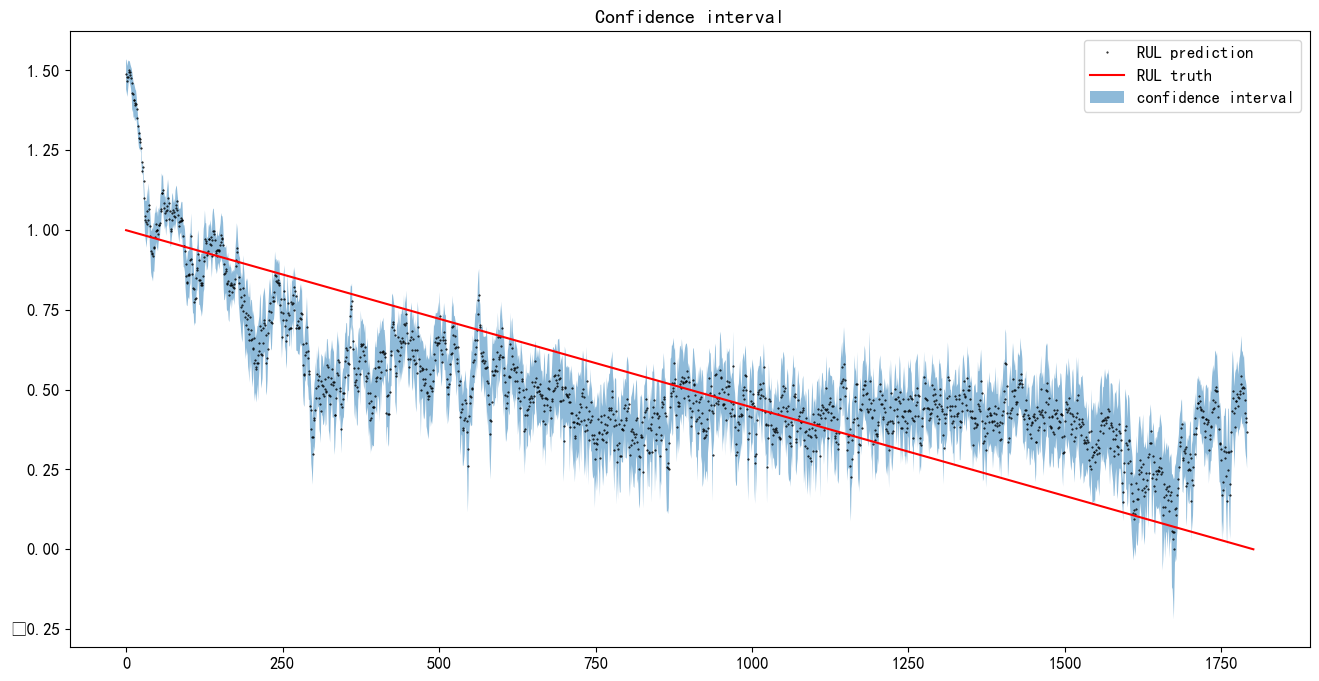

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as st
matplotlib.rcParams.update({'font.size': 12})

test_answer = np.array(test_answer)
# generate dataset
data_points = test_answer.shape[1]
sample_points = test_answer.shape[0] * test_answer.shape[1]

# predicted expect and calculate confidence interval
predicted_expect = np.mean(test_answer, 0).reshape(-1)
predicted_expect = yscaler.fit_transform(yScaler.transform(predicted_expect.reshape(-1,1))).reshape(-1)
low_CI_bound, high_CI_bound = st.t.interval(0.9, data_points - 1,
                                            loc=predicted_expect,
                                            scale=st.sem(test_answer).reshape(-1))

yTrue = y[(data_length[0]+data_length[1]):]
# plot confidence interval
x = np.linspace(0, data_points - 1, num=data_points)
plt.figure(figsize = (16,8))
plt.plot(predicted_expect,'k.',markersize = 1, label='RUL prediction')
plt.plot(yTrue, color='r', label='RUL truth')
plt.fill_between(x, low_CI_bound, high_CI_bound, alpha=0.5,
                label='confidence interval')
plt.legend()
plt.title('Confidence interval')
plt.show()

In [29]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 使用sklearn计算 MSE 、 RMSE、 MAE、r2
#test_answer = np.array(test_answer)
# generate dataset
# predicted expect and calculate confidence interval
#predicted_test = np.mean(test_answer, 0)
#my_true_test = yScaler.inverse_transform(yTest)
print("mean_absolute_error:", mean_absolute_error(yTrue[(timeStep+1):], predicted_expect))
print("mean_squared_error:", mean_squared_error(yTrue[(timeStep+1):], predicted_expect))
print("rmse:", sqrt(mean_squared_error(yTrue[(timeStep+1):], predicted_expect)))
print("r2 score:", r2_score(yTrue[(timeStep+1):], predicted_expect))

mean_absolute_error: 0.1584930792342556
mean_squared_error: 0.0365404064887125
rmse: 0.19115545110907117
r2 score: 0.5566075250325875
